In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline

## Modelos

In [85]:
def linear_model(x,m,b):
    return m*x+b

def exponential_model(x,a,b,c):
    return a*np.exp(b*x)+c

def simple_exp(x,k):
    return np.exp(k*x)

# MAGIA

In [113]:
def fecha_txt(fecha):
    meses = (None,
        'enero',
        'febrero',
        'marzo',
        'abril',
        'mayo',
        'junio',
        'julio',
        'agosto',
        'setiembre',
        'octubre',
        'noviembre',
        'diciembre')
    dia = 'primero' if fecha.is_month_start else fecha.day
    return f'{dia} de {meses[fecha.month]}'


class graph:
    def __init_graph(self, style='fivethirtyeight'):
        mpl.style.use(style)
        plt.rcParams['figure.figsize'] = [16,9]
        plt.rc('font', size=14)
        self.fig, self.ax = plt.subplots()
        self.fig.autofmt_xdate()
        self.ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
            
    def __init__(self, data, method=exponential_model, extrapolate=0):
        self.data = data
        self.method = method
        self.extrapolate = data.index.dayofyear[-1]+extrapolate
        self.__init_graph()
    
    def __getitem__(self, place):
        nonulls = self.data[place].dropna()
        return nonulls[nonulls > 0]

    def _expanded_dates(self, place_data):
        extended_size = self.extrapolate-place_data.index.dayofyear[0]+1
        dates=pd.date_range(
            start=place_data.index[0],
            periods=extended_size,
            freq='D'
        )
        return dates
        
    def _get_estimate(self, place_data):
        data_size = place_data.shape[0]
        if self.method is exponential_model:
            init = [10, 0.2, 5]
        else:
            init = None
        #init=None
        model = curve_fit(self.method, range(data_size), place_data, init)[0]
        print(model)
        dates = self._expanded_dates(place_data)
        
        estimate_data = [self.method(i, *model) for i in range(len(dates))]
        estimate = pd.DataFrame(estimate_data, index=dates)
        return estimate
    
    def plot_curve(self, place_data, color=None, label=None):
        estimate = self._get_estimate(place_data)
        if label is None:
            last_date = place_data.index[-1]
            place_name = place_data.name
            label = f'{place_name} al {fecha_txt(last_date)}'
        self.ax.plot(estimate, label=label, color=color)
        
    def plot_place(self, place, marker='x', color=None, label=None):
        place_data = self[place]
        label = place if label is None else label
        self.plot_curve(place_data, label=label)
        
        scatter_label = f'Casos {place}'
        self.ax.plot(place_data, marker, label=scatter_label, color=color)
    
    def plot_history(self, place, curves=1, shade=7, method=exponential_model):
        place_data = self[place]
        
        for n in range(curves, 0, -1):
            last_point = place_data.shape[0]-n
            partial_data = place_data[:last_point]
            self.plot_curve(partial_data)
        
        if shade < 1:
            return
        
        estimates = []
        for n in range(shade,0,-1):
            last_point = place_data.shape[0]-n
            partial_data = place_data[:last_point]
            estimate = self._get_estimate(partial_data)
            estimates += [estimate[0].tolist()]
        
        all_estimates = list(zip(*estimates))
        max_values = [max(value) for value in all_estimates]
        min_values = [min(value) for value in all_estimates]
        index = self._expanded_dates(place_data)
        plt.fill_between(index, min_values, max_values,
                         color='gray', alpha=0.2, label='Curvas Anteriores')
        
    def draw(self, title=None, xlabel='Fecha', ylabel='Infectados'):
        days = mdates.DayLocator(interval=2) 
        self.ax.xaxis.set_major_locator(days)
        days_minor = mdates.DayLocator(interval=1)  
        
        plt.legend(loc='upper left')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        self.ax.xaxis.set_tick_params(which='minor')
        plt.title(title)
        self.ax.xaxis
        
        plt.show()

In [87]:
grafico['Costa Rica'][:30]

date
2020-03-06      1.0
2020-03-07      5.0
2020-03-08      9.0
2020-03-09      9.0
2020-03-10     13.0
2020-03-11     22.0
2020-03-12     23.0
2020-03-13     26.0
2020-03-14     27.0
2020-03-15     35.0
2020-03-16     41.0
2020-03-17     50.0
2020-03-18     69.0
2020-03-19     89.0
2020-03-20    113.0
2020-03-21    117.0
2020-03-22    134.0
2020-03-23    158.0
2020-03-24    177.0
2020-03-25    201.0
2020-03-26    231.0
2020-03-27    263.0
Name: Costa Rica, dtype: float64

# Cargar datos

In [88]:
past_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_time.csv',
                      parse_dates=[1])
past_df.rename({'Country_Region': 'country',
                'Confirmed': 'cases',
                'Last_Update': 'date'}, axis=1, inplace=True)
past_df['date'] = past_df['date'].dt.normalize()
past_df = past_df.set_index('date')
past = past_df.pivot(columns='country', values='cases')


current_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv',
                         parse_dates=[1])
current_df.rename({'Country_Region': 'country',
                   'Confirmed': 'cases',
                   'Last_Update': 'date'}, axis=1, inplace=True)
current_df['date'] = current_df['date'].dt.normalize()
current_df.set_index('date')
current_df = current_df.set_index(current_df['date'])
current = current_df.pivot(columns='country', values='cases')

countries = past.append(current, sort=True, verify_integrity=True)
# If values haven't changend in the last day they probably haven't been updated.
# Remove the last data point so it doesn't influence the models.
countries.iloc[-1] = [current if last != current else None
                      for last, current
                      in zip(*countries.iloc[-2:].values)]

fecha_hoy = fecha_txt(countries.index[-1])
titulo = f'Crecimiento del COVID-19 al {fecha_hoy}'

### Reemplazo de datos
Los datos sacados de internet tienen errores o pueden no estar actualizados, los valores de `paises.csv` van a reemplazar los sacados de internet

In [89]:
paises = pd.read_csv('paises.csv', index_col=0, parse_dates=True)
countries.update(paises)

# Costa Rica Extrapolado

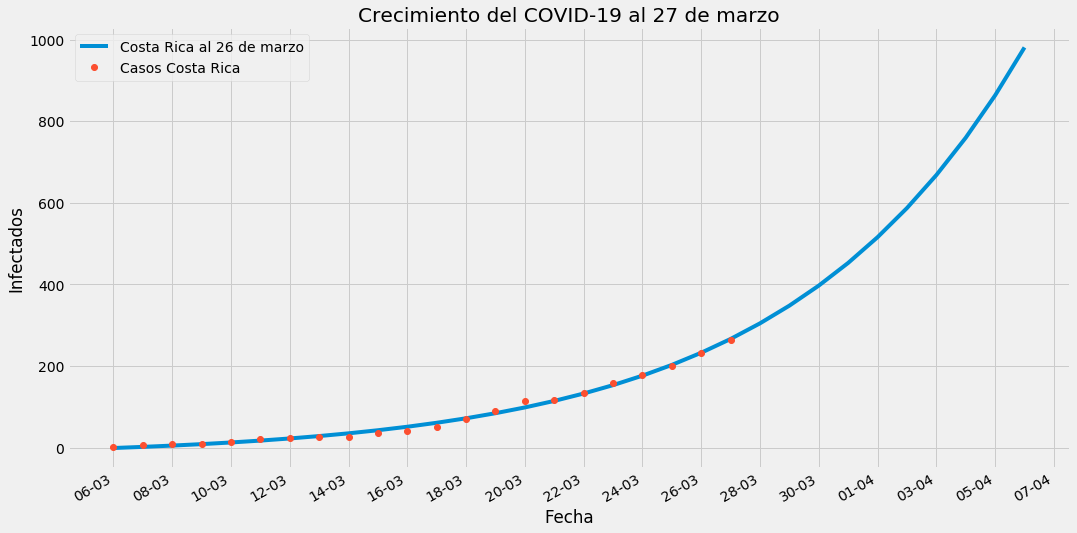

In [99]:
grafico = graph(countries, extrapolate=10, method=exponential_model)


grafico.plot_place('Costa Rica', marker='o', label='Costa Rica al 26 de marzo')


grafico.draw(titulo, xlabel='Fecha', ylabel='Infectados')

# Costa Rica con pasado

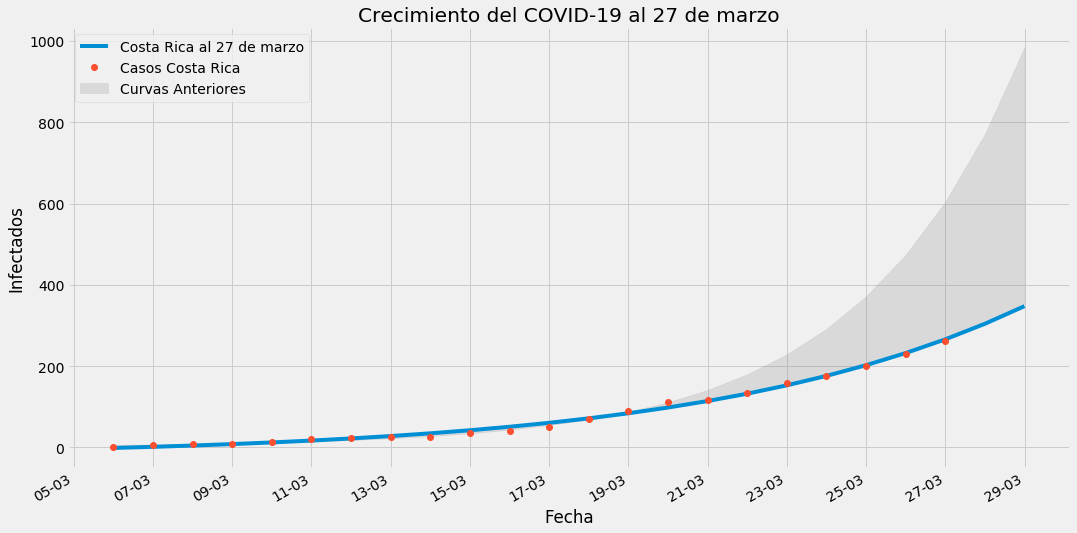

In [92]:
grafico = graph(countries, extrapolate=2)

grafico.plot_history('Costa Rica', shade=7, curves=0)
grafico.plot_place('Costa Rica', marker='o', label='Costa Rica al 27 de marzo')


grafico.draw(titulo)

# Comparacion de Paises

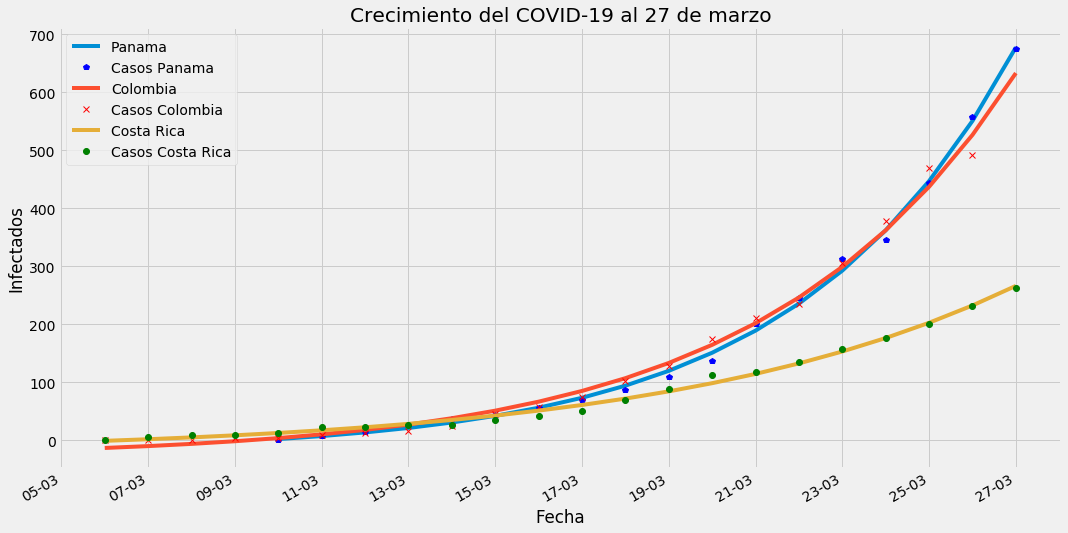

In [97]:
#paises = pd.read_csv('co.csv', index_col=0)

grafico = graph(countries, extrapolate=0)


grafico.plot_place('Panama', marker='p', color='blue')
grafico.plot_place('Colombia', marker='x', color='red')
#grafico.plot_place('Spain', marker='+')
grafico.plot_place('Costa Rica', marker='o', color='green')
#grafico.plot_place('Italy', marker='x')

grafico.draw(titulo, xlabel='Fecha', ylabel='Infectados')

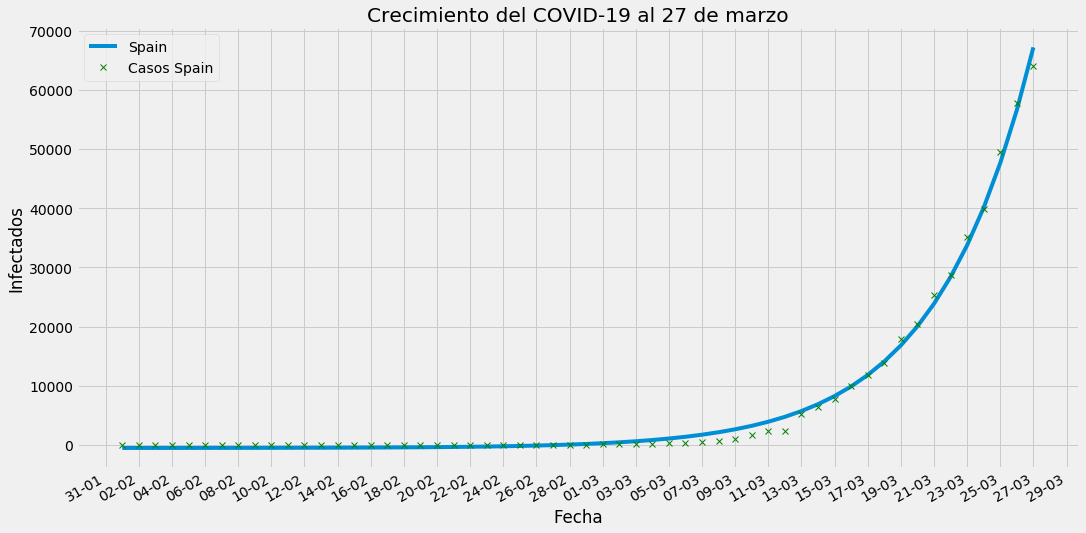

In [106]:
grafico = graph(countries)

#grafico.ax.plot(grafico['Spain'], 'o')
grafico.plot_place('Spain', marker='x', color='green')
grafico.draw(titulo)

# Comparacion de Provincias

[3.0934066 6.8241758]
[1.7967033  3.37362637]
[0.86263736 4.51648352]
[0.21428571 1.35714286]
[0.22424242 0.49090909]


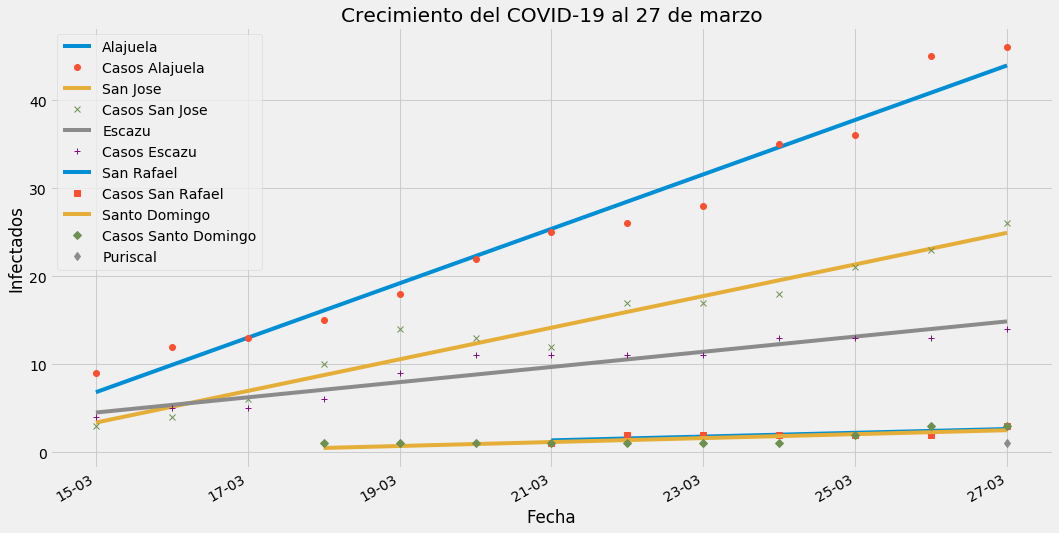

In [139]:
cantones = pd.read_csv('cantones.csv', index_col=0, parse_dates=True)
grafico = graph(cantones, method=linear_model)

grafico.plot_place('Alajuela', marker='o')
grafico.plot_place('San Jose', marker='x')
grafico.plot_place('Escazu', marker='+')
grafico.plot_place('San Rafael', marker='s')
grafico.plot_place('Santo Domingo', marker='D')
grafico.ax.plot(grafico['Puriscal'], 'd', label='Puriscal')

grafico.draw(titulo, xlabel='Fecha', ylabel='Infectados')

# Codigo Sucio. Hace cosas.

In [100]:
df = paises[:]

In [101]:
df['anterior'] = df['Costa Rica'].shift(1)
df['crecimiento'] = (df['Costa Rica'] - df['anterior'])/df['anterior']

/home/rruiz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/rruiz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [102]:
x_crecimiento = df['crecimiento'].iloc[2:]*100

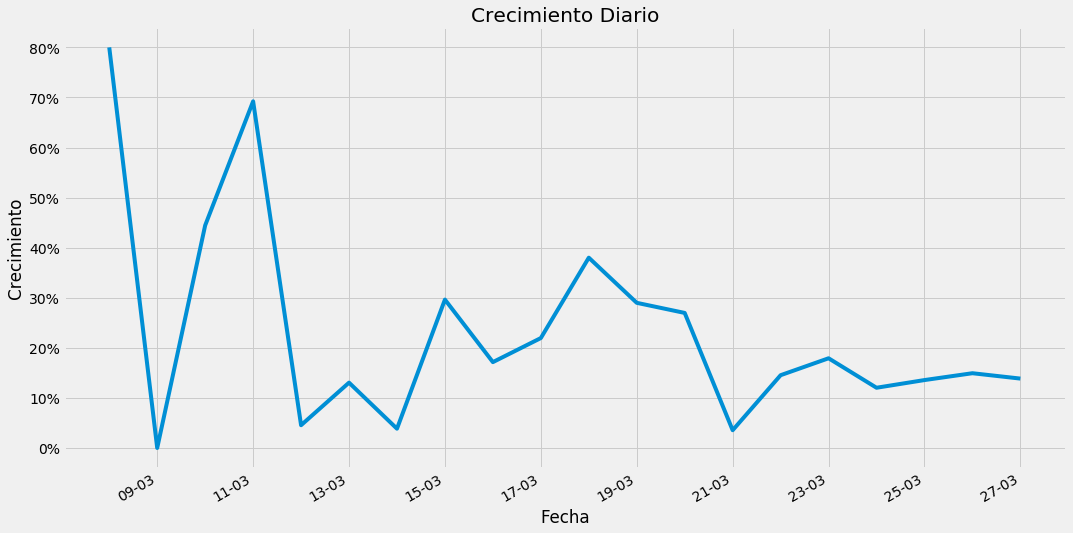

In [103]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))




x_crecimiento = df['crecimiento'].iloc[2:]*100

fechas = pd.date_range(start='3/8/2019', periods=len(x_crecimiento))
crecimiento_df = pd.DataFrame(x_crecimiento.tolist(), index=fechas)
plt.plot(crecimiento_df)
plt.title('Crecimiento Diario')
plt.xlabel("Fecha")
plt.ylabel("Crecimiento")
fig.autofmt_xdate()
plt.show()

In [104]:
df

,Costa Rica,Panama,Colombia,anterior,crecimiento
Fecha,,,,,
2020-03-06,1,0,1.0,NaN,NaN
2020-03-07,5,0,1.0,1.0,4.000000
2020-03-08,9,0,1.0,5.0,0.800000
2020-03-09,9,0,3.0,9.0,0.000000
2020-03-10,13,1,3.0,9.0,0.444444
2020-03-11,22,8,9.0,13.0,0.692308
2020-03-12,23,14,13.0,22.0,0.045455
2020-03-13,26,27,16.0,23.0,0.130435
2020-03-14,27,36,24.0,26.0,0.038462


Text(0, 0.5, 'Casos nuevos')

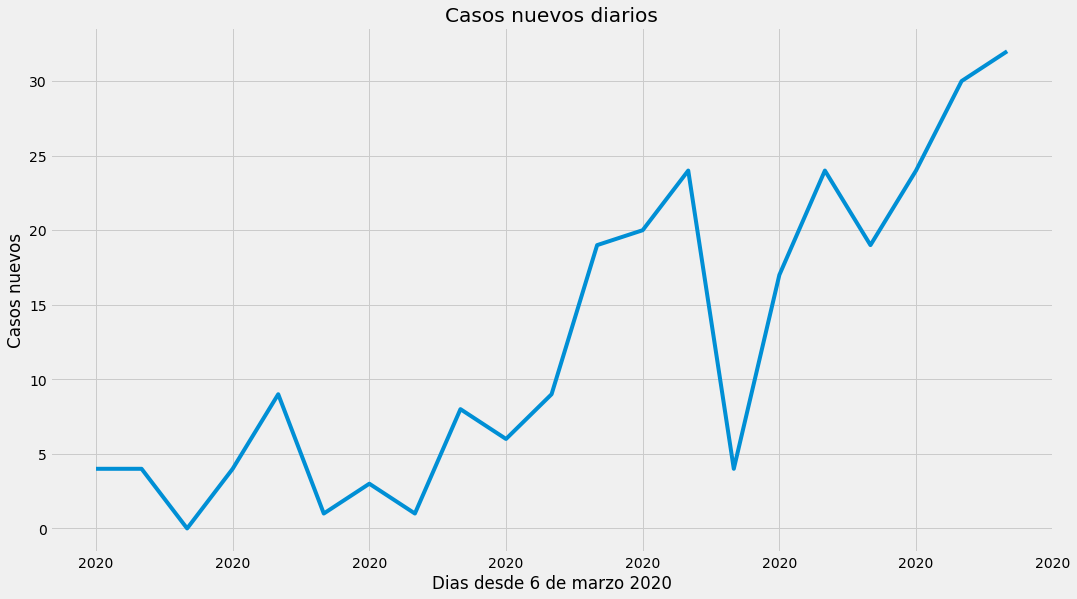

In [105]:
import matplotlib.ticker as mtick
ax = plt.figure().gca()
#...
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.plot((df['Costa Rica'] - df['anterior']))
plt.title('Casos nuevos diarios')
plt.xlabel("Dias desde 6 de marzo 2020")
plt.ylabel("Casos nuevos")